# my_module

> This module handles the first task.

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
#| default_exp my_module

In [4]:
#| export
from nbdev.showdoc import *
from pathlib import Path
import requests
import sys

# Add the current folder to the sys.path so Python can find notebook_utils
sys.path.append(str(Path.cwd()))

# Download `notebook_utils.py` if it doesn't already exist
NOTEBOOK_UTILS_PATH = Path("notebook_utils.py")
if not NOTEBOOK_UTILS_PATH.exists():
    r = requests.get(
        url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py",
    )
    NOTEBOOK_UTILS_PATH.write_text(r.text)

from notebook_utils import download_file, VideoPlayer, device_widget, quantization_widget

In [5]:
#| export
# Path to the image used for detection
IMAGE_PATH = Path("./data/coco_bike.jpg")

# Ensure the image is downloaded
download_file(
    url="https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/image/coco_bike.jpg",
    filename=IMAGE_PATH.name,
    directory=IMAGE_PATH.parent,
)

Path('C:/Users/romas/First_Task/nbs/data/coco_bike.jpg')

In [6]:
#| export
import ipywidgets as widgets

# Dropdown widget to select a model
model_id = ["yolo11n", "yolo11s", "yolo11m", "yolo11l", "yolo11x", "yolov8n", "yolov8s", "yolov8m", "yolov8l", "yolov8x"]
model_name = widgets.Dropdown(options=model_id, value=model_id[0], description="Model")
model_name

Dropdown(description='Model', options=('yolo11n', 'yolo11s', 'yolo11m', 'yolo11l', 'yolo11x', 'yolov8n', 'yolo…

In [7]:
#| export
from PIL import Image
from ultralytics import YOLO

In [8]:
#| export
# Load the YOLO model based on the selected name
DET_MODEL_NAME = model_name.value

# Load the YOLO model and ensure it is running on the CPU
det_model = YOLO(f"{DET_MODEL_NAME}.pt")
det_model.to("cpu")
label_map = det_model.model.names  # Get the label names

# Perform initial inference to test the model
res = det_model(IMAGE_PATH)
Image.fromarray(res[0].plot()[:, :, ::-1])

# Export the model to OpenVINO format if not already done
det_model_path = Path(f"{DET_MODEL_NAME}_openvino_model/{DET_MODEL_NAME}.xml")
if not det_model_path.exists():
    det_model.export(format="openvino", dynamic=True, half=True)

# Use a widget to select the device (CPU/GPU)
device = device_widget()
device


image 1/1 C:\Users\romas\First_Task\nbs\data\coco_bike.jpg: 480x640 2 bicycles, 2 cars, 2 dogs, 243.8ms
Speed: 7.2ms preprocess, 243.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


Dropdown(description='Device:', index=2, options=('CPU', 'GPU', 'AUTO'), value='AUTO')

In [9]:
#| export
import openvino as ov

Ultralytics 8.3.61  Python-3.11.4 torch-2.2.1+cpu CPU (11th Gen Intel Core(TM) i7-1165G7 2.80GHz)
Loading yolo11n_openvino_model for OpenVINO inference...
Using OpenVINO LATENCY mode for batch=1 inference...

image 1/1 C:\Users\romas\First_Task\nbs\data\coco_bike.jpg: 640x640 1 bicycle, 2 cars, 1 dog, 133.2ms
Speed: 8.6ms preprocess, 133.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


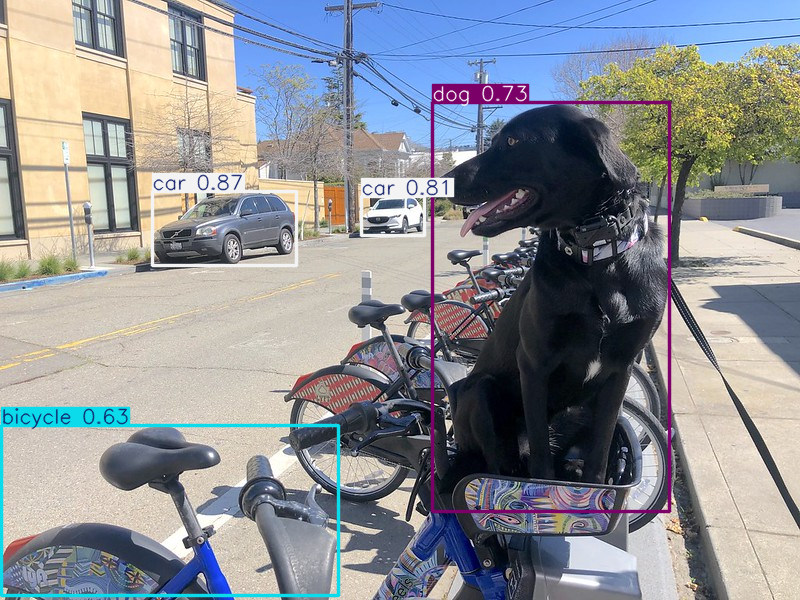

In [10]:
#| export
# Load the OpenVINO core
core = ov.Core()

# Read the OpenVINO model
det_ov_model = core.read_model(det_model_path)

# Adjust configuration based on the device
ov_config = {}
if device.value != "CPU":
    det_ov_model.reshape({0: [1, 3, 640, 640]})
if "GPU" in device.value or ("AUTO" in device.value and "GPU" in core.available_devices):
    ov_config = {"GPU_DISABLE_WINOGRAD_CONVOLUTION": "YES"}

# Compile the model for the selected device
det_compiled_model = core.compile_model(det_ov_model, device.value, ov_config)

# Load the compiled model into YOLO
det_model = YOLO(det_model_path.parent, task="detect")
if det_model.predictor is None:
    custom = {"conf": 0.25, "batch": 1, "save": False, "mode": "predict"}  # Default predictor settings
    args = {**det_model.overrides, **custom}
    det_model.predictor = det_model._smart_load("predictor")(overrides=args, _callbacks=det_model.callbacks)
    det_model.predictor.setup_model(model=det_model.model)

# Attach the compiled OpenVINO model
det_model.predictor.model.ov_compiled_model = det_compiled_model

# Perform inference using the OpenVINO model
res = det_model(IMAGE_PATH)
Image.fromarray(res[0].plot()[:, :, ::-1])

In [11]:
#| export
int8_model_det_path = Path(f"{DET_MODEL_NAME}_openvino_int8_model/{DET_MODEL_NAME}.xml")
quantized_det_model = None

In [12]:
#| export
# Quantization setup
def transform_fn(data_item: dict):
    input_tensor = det_validator.preprocess(data_item)['img'].numpy()
    return input_tensor

In [13]:
#| export
# Define the condition (whether to quantize or not)
to_quantize = quantization_widget()

# Check the condition before running the code block
if to_quantize.value:
    from ultralytics.utils import DEFAULT_CFG
    from ultralytics.cfg import get_cfg
    from ultralytics.data.converter import coco80_to_coco91_class
    from ultralytics.data.utils import check_det_dataset
    from zipfile import ZipFile
    from ultralytics.data.utils import DATASETS_DIR

    DATA_URL = "http://images.cocodataset.org/zips/val2017.zip"
    LABELS_URL = "https://github.com/ultralytics/yolov5/releases/download/v1.0/coco2017labels-segments.zip"
    CFG_URL = "https://raw.githubusercontent.com/ultralytics/ultralytics/v8.1.0/ultralytics/cfg/datasets/coco.yaml"

    OUT_DIR = DATASETS_DIR
    DATA_PATH = OUT_DIR / "val2017.zip"
    LABELS_PATH = OUT_DIR / "coco2017labels-segments.zip"
    CFG_PATH = OUT_DIR / "coco.yaml"

    if not int8_model_det_path.exists():
        download_file(DATA_URL, DATA_PATH.name, DATA_PATH.parent)
        download_file(LABELS_URL, LABELS_PATH.name, LABELS_PATH.parent)
        download_file(CFG_URL, CFG_PATH.name, CFG_PATH.parent)

        if not (OUT_DIR / "coco/labels").exists():
            with ZipFile(LABELS_PATH, "r") as zip_ref:
                zip_ref.extractall(OUT_DIR)
            with ZipFile(DATA_PATH, "r") as zip_ref:
                zip_ref.extractall(OUT_DIR / "coco/images")

        args = get_cfg(cfg=DEFAULT_CFG)
        args.data = str(CFG_PATH)
        det_validator = det_model.task_map[det_model.task]["validator"](args=args)
        det_validator.data = check_det_dataset(args.data)
        det_validator.stride = 32
        det_data_loader = det_validator.get_dataloader(OUT_DIR / "coco", 1)

        det_validator.is_coco = True
        det_validator.class_map = coco80_to_coco91_class()
        det_validator.names = label_map
        det_validator.metrics.names = det_validator.names
        det_validator.nc = 80

    # Quantization part
    import nncf

    if not int8_model_det_path.exists():
        ignored_scope = nncf.IgnoredScope(  # post-processing
            subgraphs=[
                nncf.Subgraph(inputs=[f"__module.model.{22 if 'v8' in DET_MODEL_NAME else 23}/aten::cat/Concat",
                                      f"__module.model.{22 if 'v8' in DET_MODEL_NAME else 23}/aten::cat/Concat_1",
                                      f"__module.model.{22 if 'v8' in DET_MODEL_NAME else 23}/aten::cat/Concat_2"],
                            outputs=[f"__module.model.{22 if 'v8' in DET_MODEL_NAME else 23}/aten::cat/Concat_7"])
            ]
        )

        quantized_det_model = nncf.quantize(
            det_ov_model,
            nncf.Dataset(det_data_loader, transform_fn),
            preset=nncf.QuantizationPreset.MIXED,
            ignored_scope=ignored_scope
        )
        print(f"Quantized detection model will be saved to {int8_model_det_path}")
        ov.save_model(quantized_det_model, str(int8_model_det_path))


INFO:nncf:NNCF initialized successfully. Supported frameworks detected: torch, tensorflow, openvino


In [14]:
#| export
to_quantize = quantization_widget()
# Check the condition before running the code block
if to_quantize.value:
    device

if to_quantize.value:
    if quantized_det_model is None and int8_model_det_path.exists():
        quantized_det_model = core.read_model(int8_model_det_path)

    ov_config = {}
    if device.value != "CPU":
        quantized_det_model.reshape({0: [1, 3, 640, 640]})
    if "GPU" in device.value or ("AUTO" in device.value and "GPU" in core.available_devices):
        ov_config = {"GPU_DISABLE_WINOGRAD_CONVOLUTION": "YES"}
    quantized_det_compiled_model = core.compile_model(quantized_det_model, device.value, ov_config)

    # Reconfigure the YOLO model to use the compiled OpenVINO model
    if det_model.predictor is None:
        custom = {"conf": 0.25, "batch": 1, "save": False, "mode": "predict"}  # method defaults
        args = {**det_model.overrides, **custom}
        det_model.predictor = det_model._smart_load("predictor")(overrides=args, _callbacks=det_model.callbacks)
        det_model.predictor.setup_model(model=det_model.model)

    det_model.predictor.model.ov_compiled_model = det_compiled_model

    # Inference with OpenVINO model
    res = det_model(IMAGE_PATH)
    Image.fromarray(res[0].plot()[:, :, ::-1])



image 1/1 C:\Users\romas\First_Task\nbs\data\coco_bike.jpg: 640x640 1 bicycle, 2 cars, 1 dog, 24.8ms
Speed: 9.0ms preprocess, 24.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


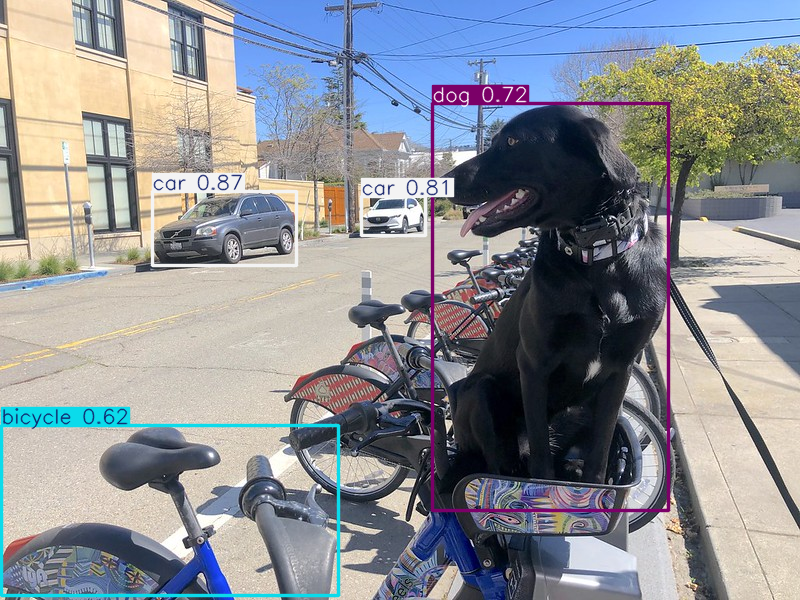

In [15]:
#| hide
# Visualization - Display the result (only for notebook)
display(Image.fromarray(res[0].plot()[:, :, ::-1]))

In [16]:
#| export

import collections
import time
from IPython import display
import cv2
import numpy as np

In [17]:
#| export
# Main processing function to run object detection.
def run_object_detection(
    source=0,
    flip=False,
    use_popup=False,
    skip_first_frames=0,
    model=det_model,
    device=device.value,
    video_width: int = None,  # if not set the original size is used
):
    player = None
    ov_config = {}
    if device != "CPU":
        model.reshape({0: [1, 3, 640, 640]})
    if "GPU" in device or ("AUTO" in device and "GPU" in core.available_devices):
        ov_config = {"GPU_DISABLE_WINOGRAD_CONVOLUTION": "YES"}
    compiled_model = core.compile_model(model, device, ov_config)

    if det_model.predictor is None:
        custom = {"conf": 0.25, "batch": 1, "save": False, "mode": "predict"}  # method defaults
        args = {**det_model.overrides, **custom}
        det_model.predictor = det_model._smart_load("predictor")(overrides=args, _callbacks=det_model.callbacks)
        det_model.predictor.setup_model(model=det_model.model)

    det_model.predictor.model.ov_compiled_model = compiled_model

    try:
        # Create a video player to play with target fps.
        player = VideoPlayer(source=source, flip=flip, fps=30, skip_first_frames=skip_first_frames)
        # Start capturing.
        player.start()
        if use_popup:
            title = "Press ESC to Exit"
            cv2.namedWindow(winname=title, flags=cv2.WINDOW_GUI_NORMAL | cv2.WINDOW_AUTOSIZE)

        processing_times = collections.deque()
        while True:
            # Grab the frame.
            frame = player.next()
            if frame is None:
                print("Source ended")
                break

            if video_width:
                # If the frame is larger than video_width, reduce size to improve the performance.
                # If more, increase size for better demo expirience.

                scale = video_width / max(frame.shape)
                frame = cv2.resize(
                    src=frame,
                    dsize=None,
                    fx=scale,
                    fy=scale,
                    interpolation=cv2.INTER_AREA,
                )

            # Get the results.
            input_image = np.array(frame)

            start_time = time.time()
            detections = det_model(input_image, verbose=False)
            stop_time = time.time()
            frame = detections[0].plot()

            processing_times.append(stop_time - start_time)
            # Use processing times from last 200 frames.
            if len(processing_times) > 200:
                processing_times.popleft()

            _, f_width = frame.shape[:2]
            # Mean processing time [ms].
            processing_time = np.mean(processing_times) * 1000
            fps = 1000 / processing_time
            cv2.putText(
                img=frame,
                text=f"Inference time: {processing_time:.1f}ms ({fps:.1f} FPS)",
                org=(20, 40),
                fontFace=cv2.FONT_HERSHEY_COMPLEX,
                fontScale=f_width / 1000,
                color=(0, 0, 255),
                thickness=1,
                lineType=cv2.LINE_AA,
            )
            # Use this workaround if there is flickering.
            if use_popup:
                cv2.imshow(winname=title, mat=frame)
                key = cv2.waitKey(1)
                # escape = 27
                if key == 27:
                    break
            else:
                # Encode numpy array to jpg.
                _, encoded_img = cv2.imencode(ext=".jpg", img=frame, params=[cv2.IMWRITE_JPEG_QUALITY, 100])
                # Create an IPython image.
                i = display.Image(data=encoded_img)
                # Display the image in this notebook.
                display.clear_output(wait=True)
                display.display(i)
    # ctrl-c
    except KeyboardInterrupt:
        print("Interrupted")
    # any different error
    except RuntimeError as e:
        print(e)
    finally:
        if player is not None:
            # Stop capturing.
            player.stop()
        if use_popup:
            cv2.destroyAllWindows()

In [18]:
#| export
WEBCAM_INFERENCE = False

if WEBCAM_INFERENCE:
    VIDEO_SOURCE = 0  # Webcam
else:
    download_file(
        "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/video/people.mp4",
        "people.mp4",
    )
    VIDEO_SOURCE = "people.mp4"


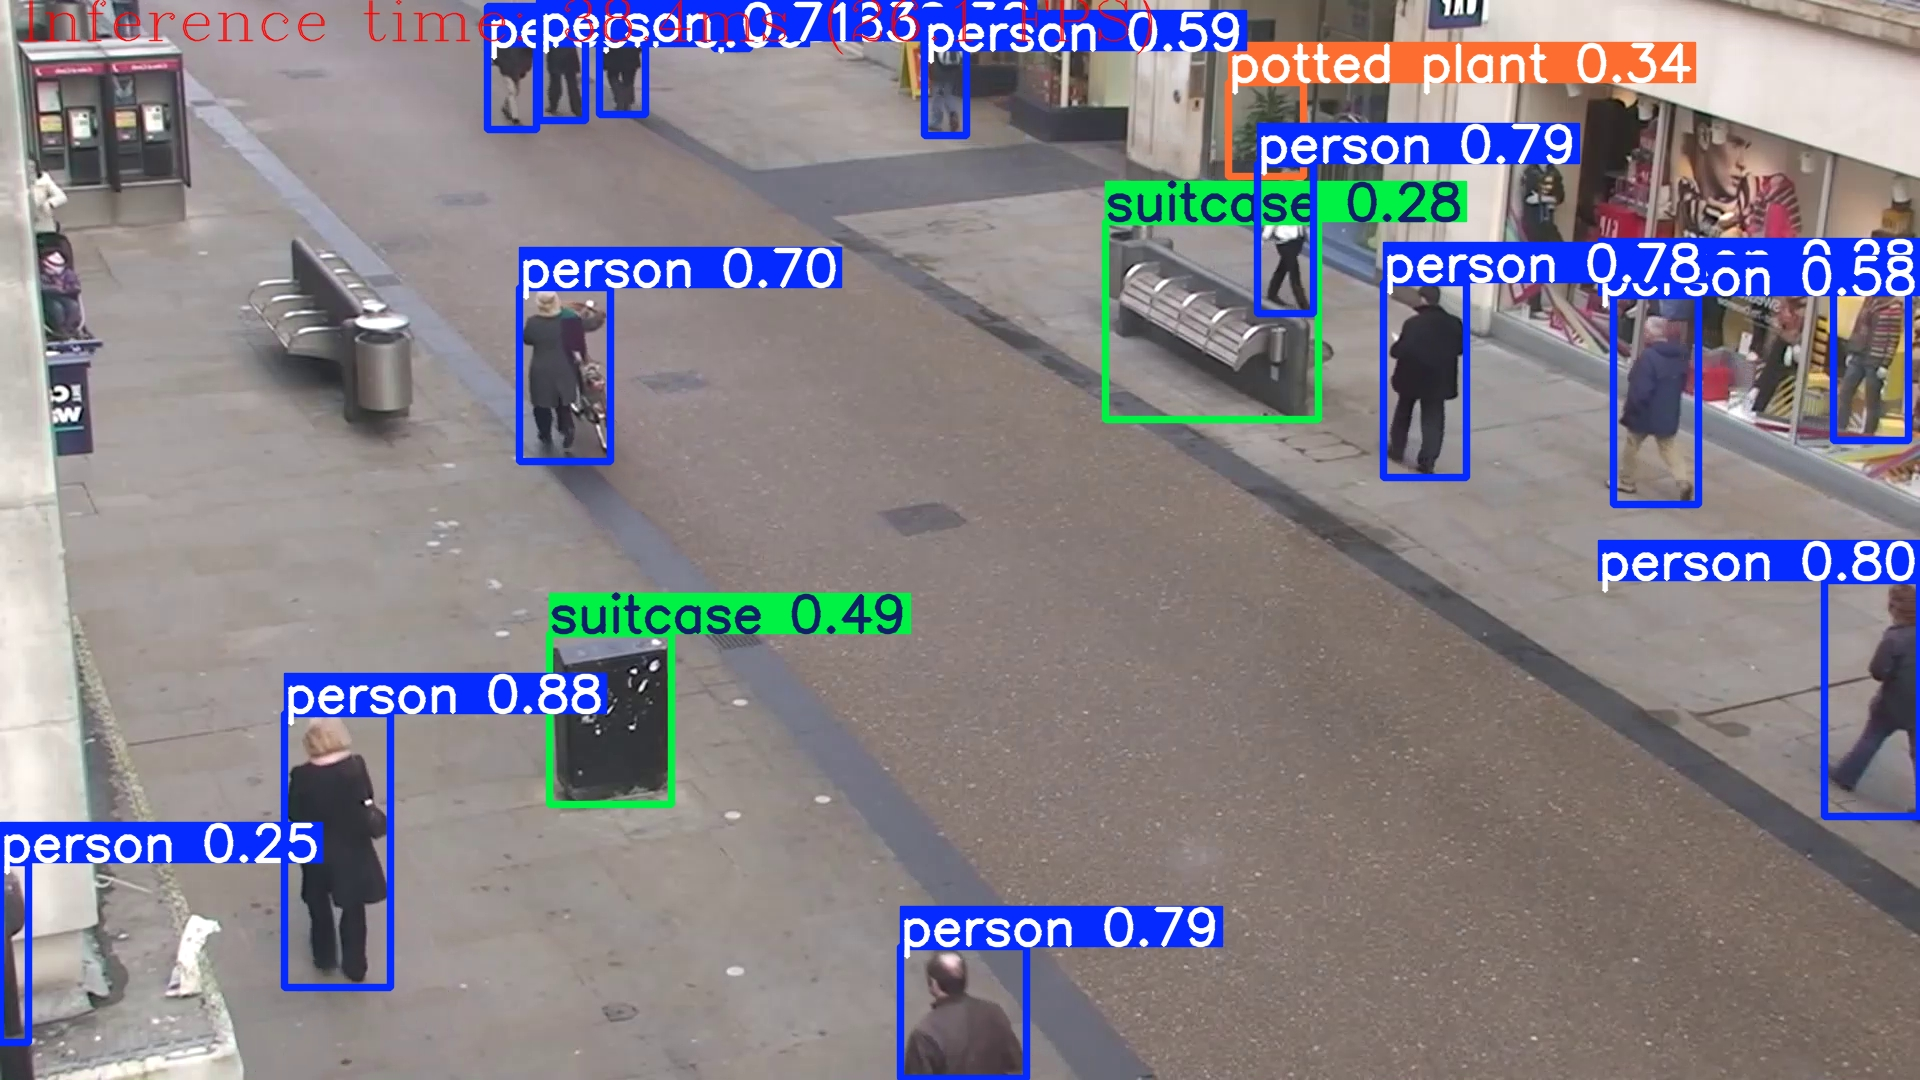

Source ended


In [19]:
#| export
run_object_detection(
    source=VIDEO_SOURCE,
    flip=True,
    use_popup=False,
    model=det_ov_model,
    device=device.value,
)

In [20]:
#| hide
import nbdev; nbdev.nbdev_export()